# Classify the CIFAR-10

## Overview

## Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm as tqdm # fancy progress bars
import matplotlib.pyplot as plt
import torchvision # for loading CIFAR dataset and visualizing images


In [2]:
torch.manual_seed(0) # for reproducibility if you care about that


In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=0.1,
    momentum=0.9,
    optimizer = "sgd",
):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Statistics dictionary
    stats = {"train_losses": [0], "test_losses": [0], "global_step": 0}

    # Training loop
    with tqdm.trange(
        num_epochs, desc="Training", unit="epoch"
    ) as epochs:  # Adjust the number of epochs
        for epoch in epochs:
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                stats["train_losses"].append(loss.item())
                stats["global_step"] += 1

                epochs.set_postfix_str(f"train loss: {stats['train_losses'][-1]:.6f}, test loss: {stats['test_losses'][-1]:.6f}")

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)

                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

            stats["test_losses"].append(test_loss / len(test_loader))

    return stats

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def plot_stats(stats):
    # Plot train and test losses
    plt.figure(figsize=(20, 4))
    plt.plot(stats["train_losses"], label="Train Loss")
    plt.plot(
        range(
            len(train_loader),
            len(stats["train_losses"]) + len(train_loader),
            len(train_loader),
        ),
        stats["test_losses"],
        label="Test Loss",
        c="r",
    )
    plt.title("Train and Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
if torch.backends.cudnn.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: mps


### LeNet-5

Training: 100%|██████████| 10/10 [00:52<00:00,  5.20s/epoch, train loss: 0.985230, test loss: 1.303186]


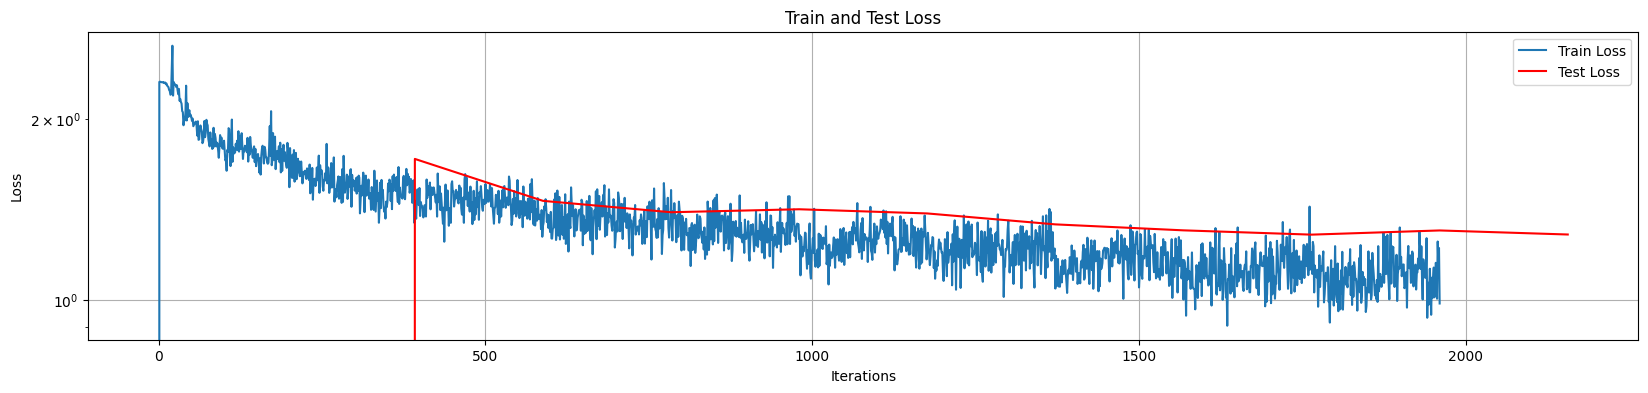

Accuracy: 0.5470
Model parameters: 240,734
Model size: 962,936 bytes


In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120*3),
    nn.Tanh(),
    nn.Linear(120*3, 84*3),
    nn.Tanh(),
    nn.Linear(84*3, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


Training: 100%|██████████| 20/20 [01:41<00:00,  5.09s/epoch, train loss: 0.956022, test loss: 1.164643]


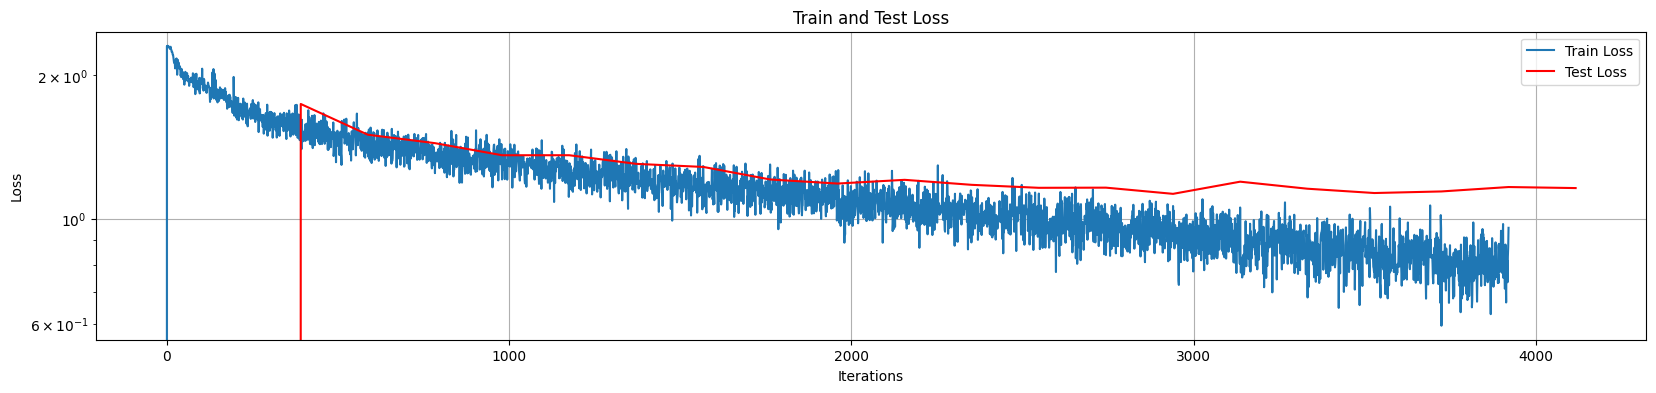

Accuracy: 0.6123
Model parameters: 240,734
Model size: 962,936 bytes


In [12]:
# Recent Model Training Techniques
# Better Optimizers
# Adam
model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120*3),
    nn.ReLU(),
    nn.Linear(120*3, 84*3),
    nn.ReLU(),
    nn.Linear(84*3, 10),
).to(device)

stats = train(model, train_loader, test_loader, num_epochs=20, lr=1e-3, optimizer="adam")

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


### AlexNet

### VGG-16

In [14]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
model = VGG('VGG16').to(device)

stats = train(model, train_loader, test_loader, num_epochs=20, lr=2e-4, optimizer="adam")

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


Training:  40%|████      | 8/20 [10:48<16:13, 81.11s/epoch, train loss: 0.068566, test loss: 0.946579]


KeyboardInterrupt: 

### ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


#### ResNet-18

In [ ]:
model = ResNet18().to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


#### ResNet-34

In [ ]:
model = ResNet34().to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")
